In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from keras.datasets import cifar10

2025-06-16 12:58:37.035896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750078717.234537      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750078717.290236      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
# Step 1: Define transforms (normalize the images)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # convert imgs into grayscale
    transforms.Resize((64,64)), # resize imgs into 64x64
    transforms.ToTensor(), #convert to tensor
    transforms.Normalize((0.5,),(0.5,)) # Normalize to [-1,1]   
])


In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Step 2: Load CIFAR-10 training and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 49.7MB/s] 


In [7]:
# Step 3: Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [8]:

# Step 4: Check the shape of one batch
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")


Image batch shape: torch.Size([64, 1, 64, 64])
Label batch shape: torch.Size([64])


In [11]:
# Get class names
class_names = train_dataset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


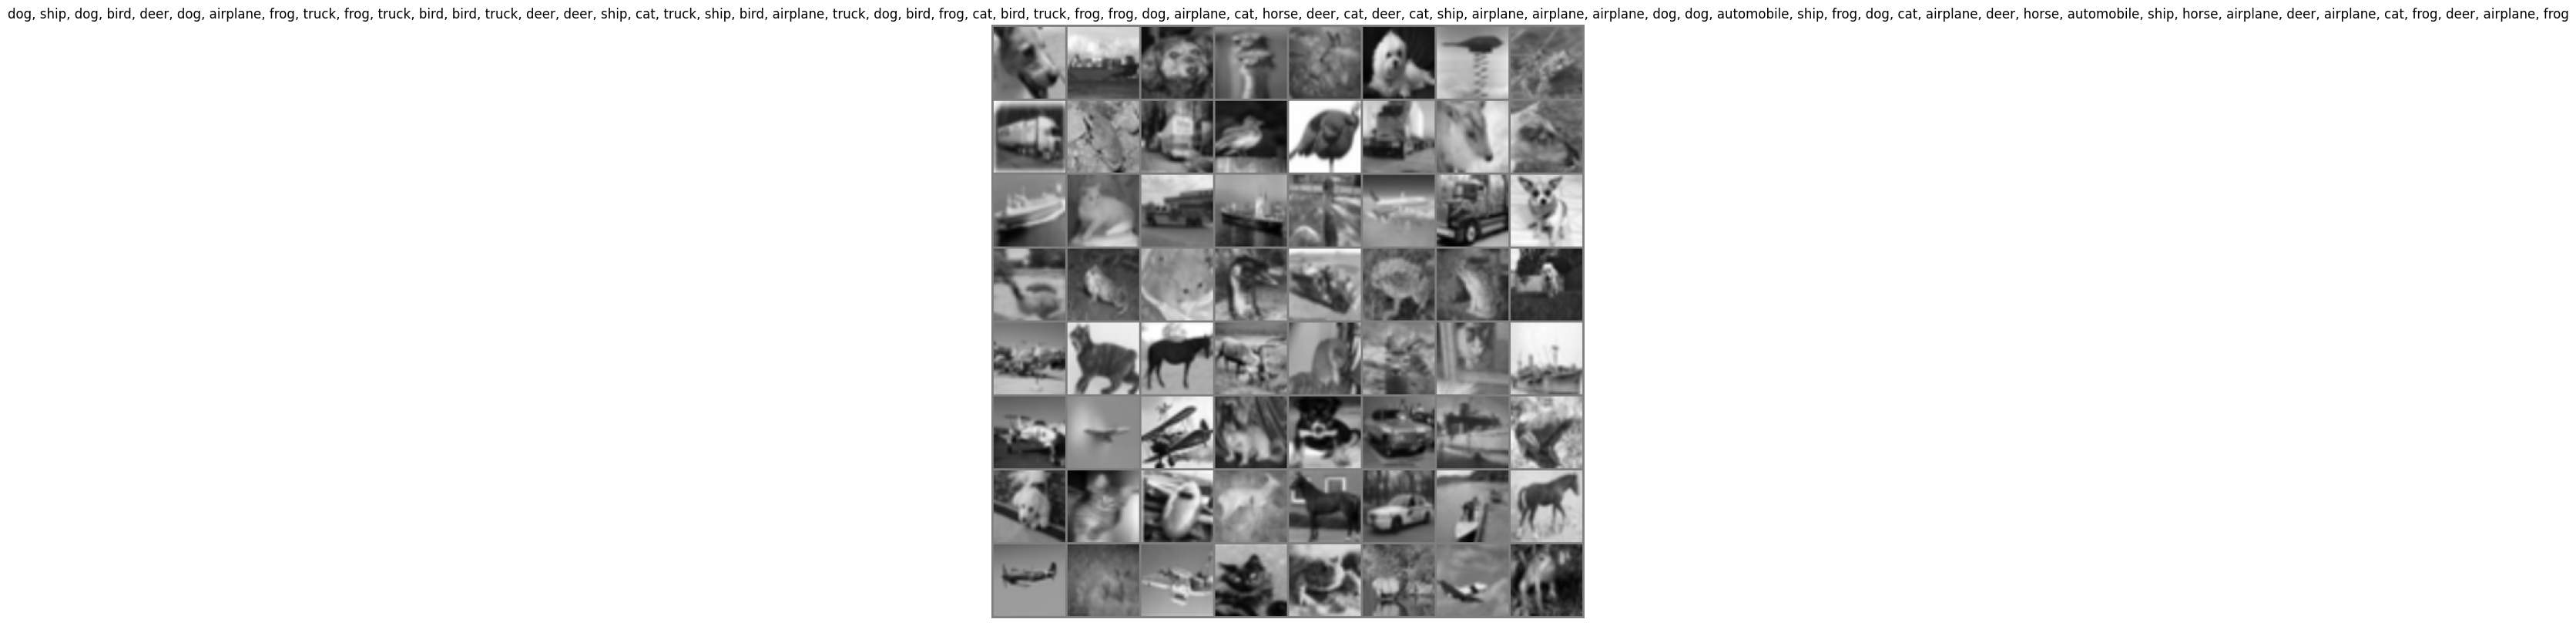

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid  # Import make_grid directly

# Helper function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))  # Adjust figure size for better visualization
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(", ".join(title))  # Display class names as a single string
    plt.axis('off')  # Turn off axis for cleaner visualization
    plt.show()

# Display a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show images
imshow(make_grid(images), title=[class_names[label] for label in labels])


# ANN

In [16]:
import torch.nn as nn
import torch.optim as optim

In [21]:
class CifarModel(nn.Module):
    def __init__(self, num_classes):
        super(CifarModel, self).__init__()
        # Flatten input directly into Fully Connected Layer(fcn)
        self.fc1 = nn.Linear(1 * 64 * 64, 128) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 16)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(16, num_classes)
        


    def forward(self, x):
        x = x.view(x.size(0),-1) # flatten the input img (64x64)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)

        return x

In [22]:
# initialize the model
num_classes = len(class_names) # set the number of classes based on the dataset
model = CifarModel(num_classes=num_classes).to('cuda') # move model to gpu if available

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to('cuda'), targets.to('cuda')


        # Flatten the input images for ANN
        inputs = inputs.view(inputs.size(0),-1) # flatten the img into 1D vector


        optimizer.zero_grad() # Clears any previously accumulated gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, targets) # compute loss
        loss.backward() # Backpropagate
        optimizer.step() # update weights


        running_loss += loss.item() # accumulate loss for reporting

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


# Testing
model.eval()
correct = 0
total = 0
with torch.no_grad(): # ensures that no gradients are calculated during the inference phase
    for inputs, targets in test_loader: # Loops over the testing dataset
        inputs, targets = inputs.to('cuda'), targets.to('cuda')

        # Flatten input images for ANN
        inputs = inputs.view(inputs.size(0), -1)  # Flatten the image to a 1D vector

        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")
        


Epoch 1/50, Loss: 1.9235
Epoch 2/50, Loss: 1.7392
Epoch 3/50, Loss: 1.6526
Epoch 4/50, Loss: 1.5885
Epoch 5/50, Loss: 1.5433
Epoch 6/50, Loss: 1.4975
Epoch 7/50, Loss: 1.4629
Epoch 8/50, Loss: 1.4340
Epoch 9/50, Loss: 1.4002
Epoch 10/50, Loss: 1.3768
Epoch 11/50, Loss: 1.3523
Epoch 12/50, Loss: 1.3291
Epoch 13/50, Loss: 1.3037
Epoch 14/50, Loss: 1.2826
Epoch 15/50, Loss: 1.2656
Epoch 16/50, Loss: 1.2449
Epoch 17/50, Loss: 1.2280
Epoch 18/50, Loss: 1.2097
Epoch 19/50, Loss: 1.1949
Epoch 20/50, Loss: 1.1782
Epoch 21/50, Loss: 1.1645
Epoch 22/50, Loss: 1.1520
Epoch 23/50, Loss: 1.1378
Epoch 24/50, Loss: 1.1219
Epoch 25/50, Loss: 1.1135
Epoch 26/50, Loss: 1.0948
Epoch 27/50, Loss: 1.0855
Epoch 28/50, Loss: 1.0738
Epoch 29/50, Loss: 1.0615
Epoch 30/50, Loss: 1.0542
Epoch 31/50, Loss: 1.0424
Epoch 32/50, Loss: 1.0298
Epoch 33/50, Loss: 1.0216
Epoch 34/50, Loss: 1.0137
Epoch 35/50, Loss: 1.0012
Epoch 36/50, Loss: 0.9927
Epoch 37/50, Loss: 0.9852
Epoch 38/50, Loss: 0.9740
Epoch 39/50, Loss: 0.

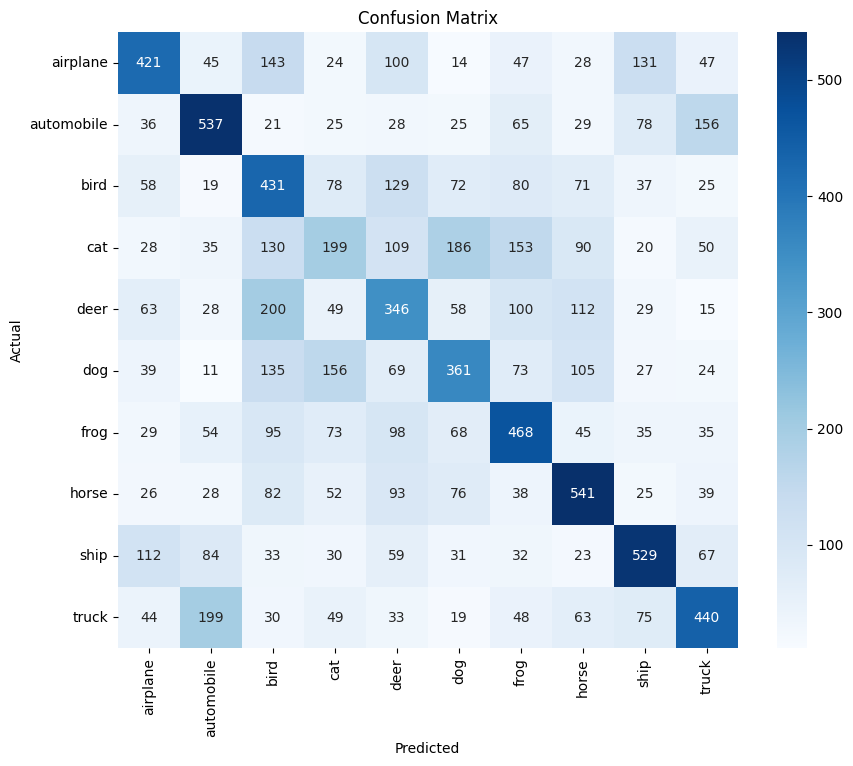

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        inputs = inputs.view(inputs.size(0), -1)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


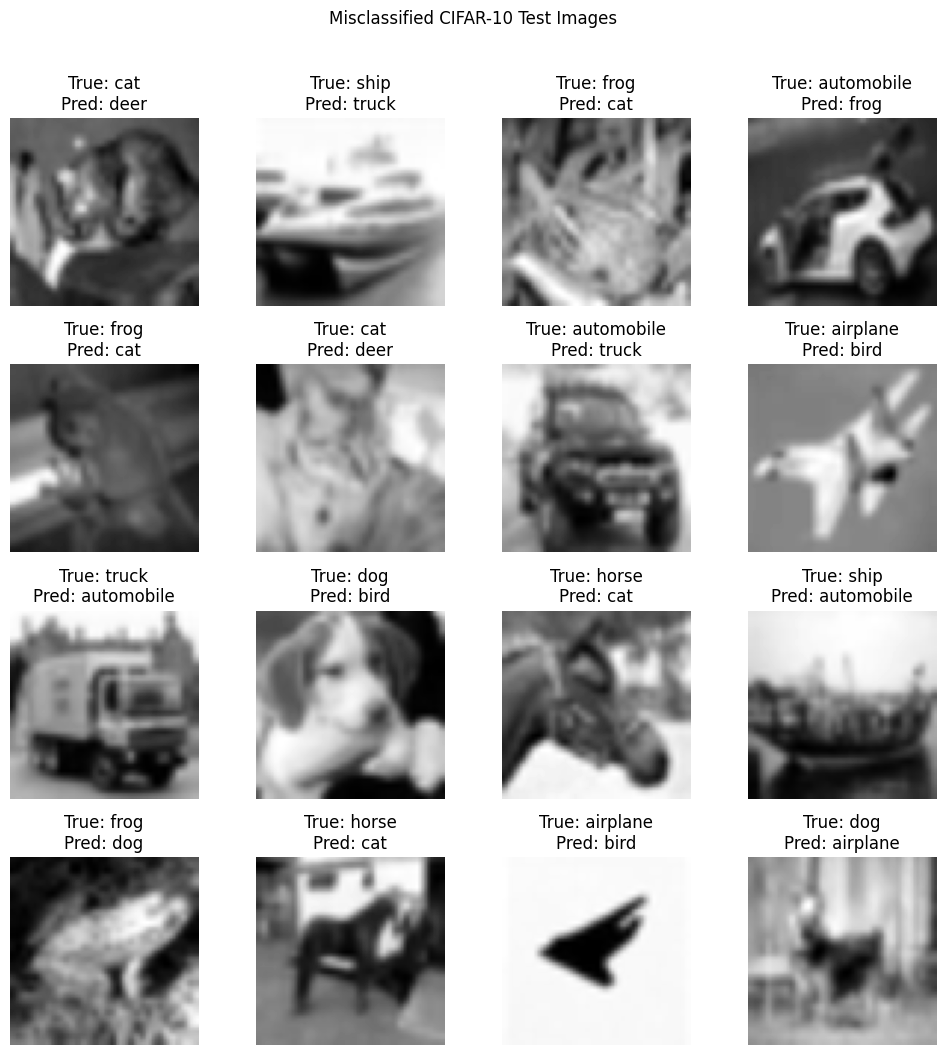

In [24]:
misclassified_imgs = []
misclassified_preds = []
misclassified_labels = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        flat_inputs = inputs.view(inputs.size(0), -1)
        outputs = model(flat_inputs)
        _, preds = torch.max(outputs, 1)

        mismatch = preds != targets
        for img, pred, label, is_wrong in zip(inputs, preds, targets, mismatch):
            if is_wrong:
                misclassified_imgs.append(img.cpu())
                misclassified_preds.append(pred.item())
                misclassified_labels.append(label.item())

            if len(misclassified_imgs) >= 16:
                break
        if len(misclassified_imgs) >= 16:
            break

# Plot 16 misclassified images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = misclassified_imgs[i].squeeze(0)  # grayscale
    ax.imshow(img.numpy(), cmap='gray')
    ax.set_title(f"True: {class_names[misclassified_labels[i]]}\nPred: {class_names[misclassified_preds[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.suptitle("Misclassified CIFAR-10 Test Images", y=1.05)
plt.show()


In [25]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'train_losses' is not defined